# s-HARM - with additive viscous term

This example gives the numerical implementation of the viscous series HARM model.

For background, see: Houlsby et al. (2017) A model for nonlinear hysteretic and ratcheting behaviour. _International Journal of Solids and Structures_ __120__ 67-80.

The Gibbs free energy $g$ and the flow potential $w$ for this model are given by:

\begin{align*}
g = & -\frac{1}{2E} \sigma^2 - \sigma \left( \sum_{n=1}^N \alpha_n + \alpha_r \right) + \frac{1}{2} \sum_{n=1}^N H_n \alpha_n^2\\
w = & \frac{1}{2\mu} \sum_{n=1}^{N} \langle |\chi_n| - k_n + R_n ( | \chi_r | - |\sigma| )\rangle^2
\end{align*}

The constraint function links the ratcheting strain with the strain in each of the slider elements:

\begin{equation*}
c_r = \dot{\alpha}_r - S(\sigma) \sum_{n=1}^N R_n |\dot{\alpha}_n| = 0
\end{equation*}

The incremental response follows from a standardised approach, which can be written in the following form:

\begin{align*}
-\dot{\epsilon} & = \frac{\partial^2 g}{\partial \sigma^2} \dot{\sigma} + \sum_{n=1}^{N} \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\alpha}_n + \frac{\partial^2 g}{\partial \sigma \partial \alpha_r} \dot{\alpha}_r \\
-\dot{\bar{\chi}}_n & = \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\sigma} + \sum_{m=1}^{N} \frac{\partial^2 g}{\partial \alpha_m \partial \alpha_n} \dot{\alpha}_n  + \frac{\partial^2 g}{\partial \alpha_r \partial \alpha_n} \dot{\alpha}_n \\
-\dot{\bar{\chi}}_r & = \frac{\partial^2 g}{\partial \sigma \partial \alpha_r} \dot{\sigma} + \sum_{n=1}^{N} \frac{\partial^2 g}{\partial \alpha_n \partial \alpha_r} \dot{\alpha}_r  + \frac{\partial^2 g}{\partial \alpha_r^2} \dot{\alpha}_r
\end{align*}

The rate of hardening strain is defined by:

\begin{equation*}
\dot{\alpha}_n = \frac{\partial w}{\partial \chi_n}
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def macaulay(x):
    x[x<0] = 0
    return x

In [3]:
# The implementation of the above equations is given below

# Model parameters
E = 10
H_n = np.array([  8,   6,   4,   2,  1])
k_n = np.array([0.2, 0.4, 0.6, 0.8,  1])
R_n = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
N = len(H_n)

# Initialise the model state parameters
epsilon = 0
chi_n = np.zeros(N)
chi_r = 0
alpha_n = np.zeros(N)
alpha_r = 0

# Define the applied stress history
sigma_max_abs_1 = 0.9
sigma_max_abs_2 = 0

d_sigma_abs = 0.001

sigma_loop = np.append(np.arange(0, sigma_max_abs_1, d_sigma_abs), 
                np.arange(sigma_max_abs_1, -sigma_max_abs_2, -d_sigma_abs))

sigma_history = np.tile(sigma_loop, 10)
epsilon_history = np.zeros(len(sigma_history))

d2_g_d_s2 = -1/E
d2_g_d_an2 =  H_n
d2_g_d_san = -np.ones(N)
d2_g_d_ans = -np.ones(N)
d2_g_d_sar = -1
d2_g_d_ars = -1

sigma_0 = 0

mu = 0.01
dt = 0.01

# Calculate the incremental response
for index, sigma in enumerate(sigma_history):
    
    d_sigma = sigma - sigma_0
        
    d_w_d_chi_n = 1 / mu * macaulay(np.abs(chi_n) - k_n + R_n * (np.abs(chi_r) - np.abs(sigma))) * np.sign(chi_n)
                
    d_alpha_n = d_w_d_chi_n * dt
    d_alpha_r = np.sign(sigma) * np.sum(R_n * np.abs(d_alpha_n))
        
    d_epsilon = - (d2_g_d_s2 * d_sigma + np.sum(d2_g_d_san * d_alpha_n) + d2_g_d_sar * d_alpha_r )
    d_chi_n = - (d2_g_d_ans * d_sigma + d2_g_d_an2 * d_alpha_n)
    d_chi_r = - d2_g_d_ars * d_sigma
        
    epsilon = epsilon + d_epsilon
    chi_n = chi_n + d_chi_n
    chi_r = chi_r + d_chi_r
    alpha_n = alpha_n + d_alpha_n
    alpha_r = alpha_r + d_alpha_r
    
    sigma_0 = sigma
            
    epsilon_history[index] = epsilon   

Text(0,0.5,'$\\sigma$')

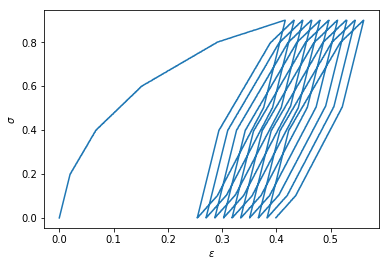

In [4]:
plt.plot(epsilon_history, sigma_history)
plt.xlabel('$\epsilon$')
plt.ylabel('$\sigma$')